STEP - 1 : IMPORT THE REQUIRED LIBRARIES

In [1]:
# A. Import Basic Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math

# B. Import Libraries Required For ARIMA Model
import statsmodels.api as sm

# C. Import Libraries Required For Developing ML Models
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
! pip install lightgbm
from lightgbm import LGBMRegressor

# D. Import Libraries Required For Hypertuning The ML Models
from sklearn.model_selection import GridSearchCV

# E. Import Libraries Required For Evaluating The ML Models
from sklearn.metrics import mean_squared_error

STEP - 2 : LOAD THE DATA

In [2]:
file_path = r"C:\Users\titik\OneDrive\Desktop\Data Science\Analytics Capstone Project\amz_uk_processed_data.csv"
data = pd.read_csv(file_path)
# Take 35% Of Data
data_sample = data.sample(frac=0.35, random_state=42)
data_sample.head(1)

,asin,title,imgUrl,productURL,stars,reviews,price,isBestSeller,boughtInLastMonth,categoryName
673381,B00XLHSZ74,AQUALONA® Premium Thermoplastic Toilet Seat - ...,https://m.media-amazon.com/images/I/21PBcPK8A0...,https://www.amazon.co.uk/dp/B00XLHSZ74,4.5,393,26.99,False,1000,Kitchen & Bath Fixtures


In [3]:
data_sample.shape # Rows and Columns of dataset respectively

(777960, 10)

STEP - 3 : DATA PREPARATION

3.1. FEATURE ENGINEERING

(I) DROP UNREQUIRED FEATURES AND RENAME THE REQUIRED ONES

In [4]:
# (A) Drop The Unrequired Columns From The Dataframe
data_sample = data_sample.drop(['asin','imgUrl', 'productURL', 'boughtInLastMonth'], axis = 1)

In [5]:
# (B) Rename The Columns Names
data_sample = data_sample.rename(columns = {'stars' : 'Stars', 'reviews' : 'Reviews', 'price' : 'Price', 
                              'isBestSeller' : 'IsBestSeller', 'categoryName' : 'CategoryName'})

(II) ADD FEATURES REQUIRED FOR DEVELOPING ML MODELS

In [6]:
# (A) Extract Brand Name And Product Name Using str.split()
data_sample['Brand Name'] = data_sample['title'].str.split('|').str[0].str.split().str[0]
data_sample['Product Name'] = data_sample['title'].str.split().str[1:].str.join(' ')

In [7]:
# (B) Compute Brand Strength
# 0 = unfamous brand, 1 = famous brand
data_sample['Brand Strength'] = data_sample['IsBestSeller'].astype(int)

In [8]:
# (C) Compute Popularity Score
# Approximate popularity score for each product (multiply stars with reviews)
data_sample['Popularity Score'] = data_sample['Stars']*data_sample['Reviews']

In [9]:
# (D) Compute Price Elasticity
# Lower the price elasticity, price change won't lose sales (i.e., product is more popular and can handle price change)
data_sample['Price Elasticity'] = data_sample['Price']/(data_sample['Popularity Score'])

In [10]:
# (E) Compute Inventory Turnover Rate
# Higher ITR : Fast Moving Products while Lower ITR : Potential Overstock
data_sample['Inventory Turnover Rate'] = data_sample['Reviews']/data_sample['Price']

In [11]:
# (F) Compute Category Level Market Share
# Higher the market share, higher the dominance in that particular category
data_sample['Market Share'] = data_sample['Reviews'] / data_sample.groupby('CategoryName')['Reviews'].transform('sum')

In [12]:
# (G) Compute Revenue
# Total amount of money generated from sales : higher the revenue, higher the profit (sales performance)
data_sample['Revenue'] = data_sample['Price'] * data_sample['Popularity Score']

In [13]:
# (H) Compute Profit
# Remains after all expenses deducted from revenue
data_sample['Cost Percentage'] = 0.7 * data_sample['Price']
data_sample['Profit'] = (data_sample['Price'] * (1 - data_sample['Cost Percentage'])) * data_sample['Popularity Score']

Important Features : 

1. Price Elasticity, Competitor Price Comparison, Sale Growth : gives in depth details of product sales
2. Inventory Turnover Rate : gives in depth details of stock inventory

(III) ADD FEATURES REQUIRED FOR DATETIMESTAMP AND CHECKING BERRISH/BULLISH SIGNALS

In [14]:
#Given the information, data has been scrapped in October 2023

np.random.seed(42) 

# (A) Compute the Year And Month {random} package
data_sample['Year'] = np.random.choice([2023], size=len(data_sample))
data_sample['Month'] = np.random.randint(10, 13, size=len(data_sample))

In [15]:
# (B) Moving Average For Price
# Short Term MA
data_sample['MA_50_Price'] = data_sample['Price'].rolling(window = 50, min_periods = 1).mean()
# Long Term MA
data_sample['MA_200_Price'] = data_sample['Price'].rolling(window = 200, min_periods = 1).mean()

In [16]:
# (D) MA Signals Bullish / Berrish
# If Short Term MA > Long Term MA meaning prices rising in Short Term as compared to Long Term thus Bullish signal else Berrish
data_sample['Bullish/Berrish_Price'] = np.where(data_sample['MA_50_Price'] > data_sample['MA_200_Price'], 'Bullish', 'Berrish')

3.2. CLEAN THE DATA

(I) DROP NaN and inf Values FROM THE DATASET

In [17]:
data_sample = data_sample.dropna()

(II) DROP UNNECESARY FEATURES SINCE FEATURE ENGINEERING IS COMPLETE AND NOT MORE NEEDED

In [18]:
data_sample = data_sample.drop(['title', 'Stars', 'Reviews', 'IsBestSeller', 'Brand Strength'], axis=1)

STEP - 4 : PERFORM EXPLORATORY DATA ANALYSIS

4.1. UNDERSTAND THE DATA

In [19]:
data_sample.head(1) # Get the first row of dataset

,Price,CategoryName,Brand Name,Product Name,Popularity Score,Price Elasticity,Inventory Turnover Rate,Market Share,Revenue,Cost Percentage,Profit,Year,Month,MA_50_Price,MA_200_Price,Bullish/Berrish_Price
673381,26.99,Kitchen & Bath Fixtures,AQUALONA®,Premium Thermoplastic Toilet Seat - Soft Close...,1768.5,0.015262,14.560948,0.0004,47731.815,18.893,-854065.365795,2023,12,26.99,26.99,Berrish


In [20]:
data_sample.tail(1) # Get the last row of dataset

,Price,CategoryName,Brand Name,Product Name,Popularity Score,Price Elasticity,Inventory Turnover Rate,Market Share,Revenue,Cost Percentage,Profit,Year,Month,MA_50_Price,MA_200_Price,Bullish/Berrish_Price
1346918,26.77,Sports & Outdoors,Tennis,"Racket, Ultralight Carbon Tennis Racket, PU Wr...",0.0,inf,0.0,0.0,0.0,18.739,-0.0,2023,11,318.2108,136.3453,Bullish


In [21]:
data_sample.shape # Rows and Columns of dataset respectively

(777881, 16)

In [22]:
data_sample.dtypes # Datatypes of the features within dataset

Price                      float64
CategoryName                object
Brand Name                  object
Product Name                object
Popularity Score           float64
Price Elasticity           float64
Inventory Turnover Rate    float64
Market Share               float64
Revenue                    float64
Cost Percentage            float64
Profit                     float64
Year                         int32
Month                        int32
MA_50_Price                float64
MA_200_Price               float64
Bullish/Berrish_Price       object
dtype: object

----- UNDERSTANDING FEATURES OF DATASET -----

(A) ALREADY EXISTING FEATURES

1. Product Name : this feature has the name of the product
2. CategoryName : this feature contains the category name of the product
tor Price
3. Price : this feature has price of the product

(B) FEATURES ADDED IN FEATURE ENGINEERING

1. Brand Name : this feature has the brand name of the product
4. Popularty Score : this feature gives information of how popular the product is
5. Price Elasticity : this feature gives information of if and how the price change affects the sales of product
6. Inventory Turnover Rate : this feature gives information of if the product lies in category of FMG or potential overstock
8. Market Share : this feature tells the dominance of category of product in market
9. Year : this feature tells the year of the product was sold
10. Month : this feature tells the month of the product was sold in numeric
11. MA_50_Price : this feature contains the moving average of price within 50 rolling window
12. MA_200_Price : this feature contains the moving average of price within 200 rolling window
13. Bullish/Berrish_Price : this feature gives if fluctuation is positive (Bullish) or negative (Berrish) for price

In [23]:
data_sample.isna().sum() # If any null values within dataset

Price                      0
CategoryName               0
Brand Name                 0
Product Name               0
Popularity Score           0
Price Elasticity           0
Inventory Turnover Rate    0
Market Share               0
Revenue                    0
Cost Percentage            0
Profit                     0
Year                       0
Month                      0
MA_50_Price                0
MA_200_Price               0
Bullish/Berrish_Price      0
dtype: int64

4.2. DESIGN VISUALIZATIONS

(I) CORRELATION BETWEEN PRICE AND PRICE ELASTICITY

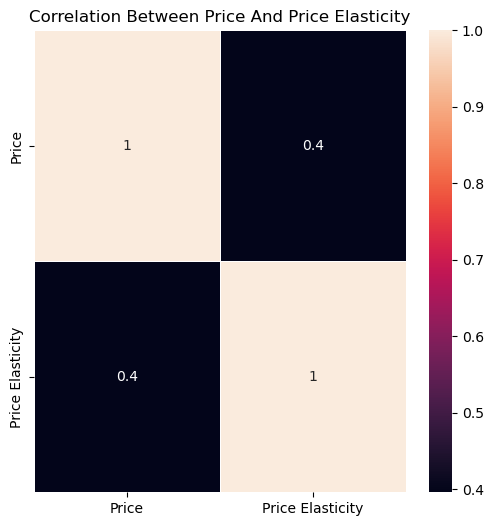

In [24]:
corr_matrix = data_sample[['Price', 'Price Elasticity']].corr()

plt.figure(figsize=(6, 6))
sns.heatmap(corr_matrix, annot=True, linewidths=0.5)
plt.title("Correlation Between Price And Price Elasticity")
plt.show()

Insights Drawn :
1. There is potentially good correlation between Price and Price Elasticity features (40%), meaningly there are chances of increase in profit
2. If Price Elasticity is less as compared to Price then product can handle the price change

Conclusion : 

The particular product whose Price Elasticity is lower can help in increasing slight sales thus leading to increase in slight profit 

(II) POPULARITY SCORE, MARKET SHARE AND INVENTORY TURNOVER RATE VISUALIZATION BY PRICE

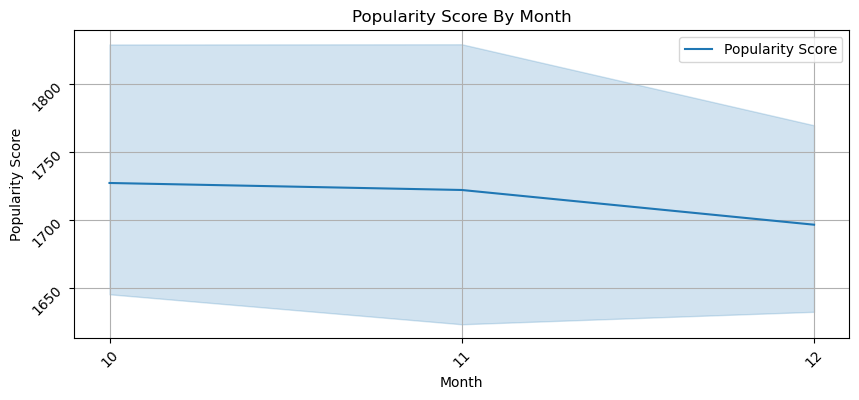

In [25]:
plt.figure(figsize=(10, 4))
sns.lineplot(x='Month', y='Popularity Score', data=data_sample, label='Popularity Score')
plt.title("Popularity Score By Month")
plt.xlabel("Month")
plt.ylabel("Popularity Score")
plt.xticks(ticks = [10, 11, 12], rotation=45)
plt.yticks(rotation=45)
plt.grid()
plt.show()

Insights Drawn : 

The drop of Popularity Growth from October to December depicts the decrease in customer satisfaction throughout the time

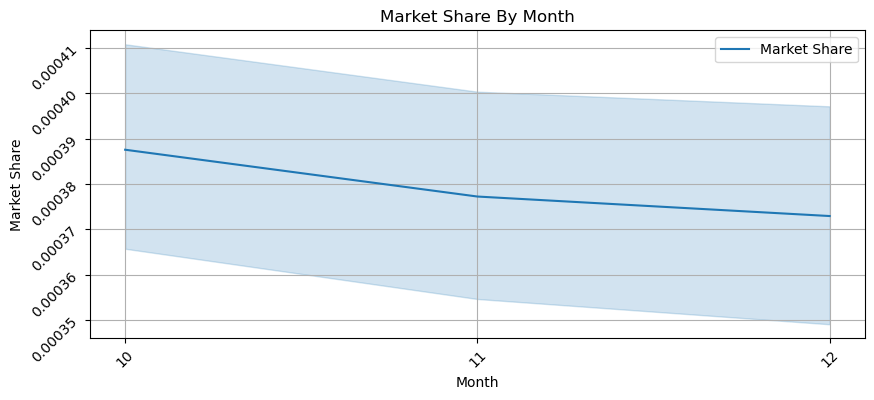

In [26]:
plt.figure(figsize=(10, 4))
sns.lineplot(x='Month', y='Market Share', data=data_sample, label='Market Share')
plt.title("Market Share By Month")
plt.xlabel("Month")
plt.ylabel("Market Share")
plt.xticks(ticks = [10, 11, 12], rotation=45)
plt.yticks(rotation=45)
plt.grid()
plt.show()

Insights Drawn : 

1. There was sudden drop of Market Share in November month
2. Then there was slight increase of Market Share in December month

Conclusion : 

1. The overall Market Share trend suggests that though there was drop in November, there was still slight recovery phase but not strong in December.
2. This suggests the need for ongoing market analysis and strategic price adjustments to ensure sustainable market growth

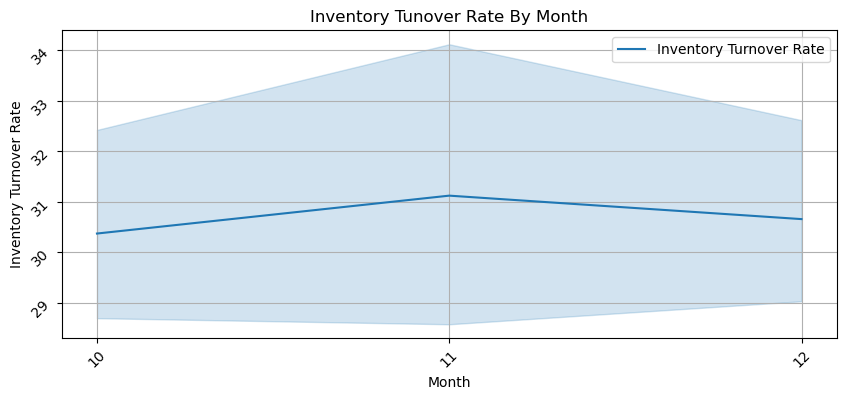

In [27]:
plt.figure(figsize=(10, 4))
sns.lineplot(x='Month', y='Inventory Turnover Rate', data=data_sample, label='Inventory Turnover Rate')
plt.title("Inventory Tunover Rate By Month")
plt.xlabel("Month")
plt.ylabel("Inventory Turnover Rate")
plt.xticks(ticks = [10, 11, 12], rotation=45)
plt.yticks(rotation=45)
plt.grid()
plt.show()

Insights Drawn :

1. There was sudden increase of Inventory Turnover Rate in November
2. Then there was slight increase of Inventory Turnover Rate in December

Conclusion :

1. The overall Inventory Turnover Rate trend suggest there was slight potential overstocking of products in December after coming from the fast moving good (FMG) phase from November.
2. This suggests the less demand of products and slight loss to the company by the end of the year

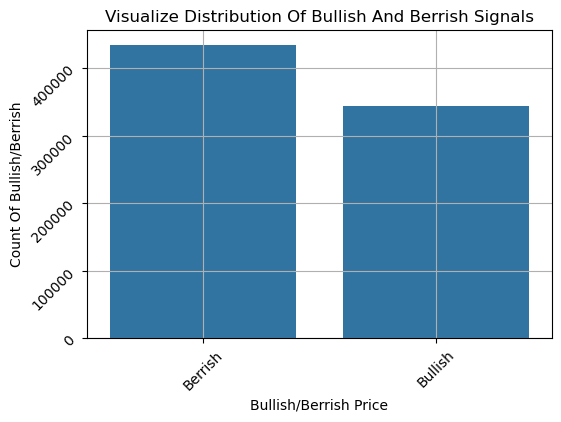

In [28]:
plt.figure(figsize = (6,4))
sns.countplot(data = data_sample, x = 'Bullish/Berrish_Price')
plt.xlabel('Bullish/Berrish Price')
plt.ylabel('Count Of Bullish/Berrish')
plt.title('Visualize Distribution Of Bullish And Berrish Signals')
plt.grid()
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)
plt.show()

Insights Drawn :

There were more Berrish signals as compared to Bullish signals

Conclusion :

The Berrish/Bullish trend suggests there were less number of sales by the end of year throughout October to November emphasizing the need of optimal pricing strategies

(V) OVERALL CONCLUSION FROM EDA 

1. Though, after analyzing main features like Popularity Score, Market Share, Inventory Turnover Rate and Berrish/Bullish signals there were possibilities of loss by the end of year. 
2. But, upon analyzing price related features mainly Price and Price Elasticity; there was a slight growth in market, competitive prices
3. Thus, by opting strategical price methods there are chances of improvising profitability by staying in competitive market

(VI) POSSIBLE CAUSES FOR THE POOR CONSUMER BEHAVIOUR 

1. Holidays / Promotions
2. A Mix Of Seasonal Shopping Patterns
3. Better quality products over offline shops or other ecommerce platforms
4. Shipping cost
5. Unoptimal prices of products
6. Poor quality of products
7. Unavailability of particular product in stock

STEP - 5 : DEVELOPE TIME SERIES (ARIMA : Auto Regressive Integrated Moving Average) MODEL

(A) ADD DATE FEATURE SINCE IT WAS NOT PRESENT INITIALLY

In [29]:
# Calculate Days And Add Date With Days, Months And Years Since Date Feature Is Not Present In Dataset
# Map Days To Month
days_in_month = {10: 31, 11: 30, 12: 31}
# Assign Day Based On Month Value
data_sample['Day'] = data_sample['Month'].map(days_in_month)
# Combine Year, Month And Day To Date Feature
data_sample['Date'] = pd.to_datetime(data_sample[['Year', 'Month', 'Day']])
data_sample.head(1)

,Price,CategoryName,Brand Name,Product Name,Popularity Score,Price Elasticity,Inventory Turnover Rate,Market Share,Revenue,Cost Percentage,Profit,Year,Month,MA_50_Price,MA_200_Price,Bullish/Berrish_Price,Day,Date
673381,26.99,Kitchen & Bath Fixtures,AQUALONA®,Premium Thermoplastic Toilet Seat - Soft Close...,1768.5,0.015262,14.560948,0.0004,47731.815,18.893,-854065.365795,2023,12,26.99,26.99,Berrish,31,2023-12-31


(B) DEVELOPE AND FIT THE ARIMA MODEL

ARIMA Model Order :
1. p : set this term for AR (Auto Regressive) to 1, that defines how many past values model uses to predict current value
2. d : set this term for I (Integrated) to 1, that defines number of times data has been differenced to make it stationary 
3. q : set this term for MA (Moving Average) to 1, that defines how many forecast error model uses to predict current value

In [30]:
# Develope ARIMA Model 
ARIMA_model = sm.tsa.ARIMA(data_sample[['Price']], order = (1, 1, 1))
# Fit ARIMA Model
model_fit = ARIMA_model.fit()

C:\Users\titik\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\titik\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\titik\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


(C) MAKE ARIMA PREDICTIONS

In [31]:
# Forecasted Prices (i.e., ARIMA Predictions)
Forecasted_Prices = model_fit.predict(start=1, typ='levels')
data_sample['ARIMA_ForecastedPrices'] = Forecasted_Prices
data_sample.head(1)

,Price,CategoryName,Brand Name,Product Name,Popularity Score,Price Elasticity,Inventory Turnover Rate,Market Share,Revenue,Cost Percentage,Profit,Year,Month,MA_50_Price,MA_200_Price,Bullish/Berrish_Price,Day,Date,ARIMA_ForecastedPrices
673381,26.99,Kitchen & Bath Fixtures,AQUALONA®,Premium Thermoplastic Toilet Seat - Soft Close...,1768.5,0.015262,14.560948,0.0004,47731.815,18.893,-854065.365795,2023,12,26.99,26.99,Berrish,31,2023-12-31,NaN


In [32]:
# Replace NaN With Mean
mean_forecasted_price = data_sample['ARIMA_ForecastedPrices'].mean()
data_sample['ARIMA_ForecastedPrices'].fillna(mean_forecasted_price, inplace = True)
data_sample.head(1)

C:\Users\titik\AppData\Local\Temp\ipykernel_17608\597489140.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_sample['ARIMA_ForecastedPrices'].fillna(mean_forecasted_price, inplace = True)


,Price,CategoryName,Brand Name,Product Name,Popularity Score,Price Elasticity,Inventory Turnover Rate,Market Share,Revenue,Cost Percentage,Profit,Year,Month,MA_50_Price,MA_200_Price,Bullish/Berrish_Price,Day,Date,ARIMA_ForecastedPrices
673381,26.99,Kitchen & Bath Fixtures,AQUALONA®,Premium Thermoplastic Toilet Seat - Soft Close...,1768.5,0.015262,14.560948,0.0004,47731.815,18.893,-854065.365795,2023,12,26.99,26.99,Berrish,31,2023-12-31,94.644415


***NOTE***

Here we have obtained the forecasted prices using a Time Series model, i.e., ARIMA model whose output (Forecasted Prices) will be used as input for the Machine Learning models in order to predict optimal prices

STEP - 6 : PRE-REQUISITES FOR DEVELOPING ML MODELS

6.1. SELECT REQUIRED FEATURES 

In [33]:
mlModel_features = data_sample[['ARIMA_ForecastedPrices','Popularity Score', 'Price Elasticity', 
                                'Inventory Turnover Rate', 'Market Share', 'Revenue', 'Profit']]
mlModel_features.head(1)

,ARIMA_ForecastedPrices,Popularity Score,Price Elasticity,Inventory Turnover Rate,Market Share,Revenue,Profit
673381,94.644415,1768.5,0.015262,14.560948,0.0004,47731.815,-854065.365795


1. We have used target variable Price for Time Series model and obtained Forecasted Prices with AR, I and MA set to 1 which means throughout the calculations one past value; one differencing and one forecasted error were used for ARIMA modeling
2. Since we have obtained new dynamic Forecasted Prices after using Time Series model, this is our new target variable throughout developing and evaluating ML Models

6.2. GET THE TRAIN AND TEST DATASET

In [34]:
# Where, test_size = 20% & train_size = 80%
X = mlModel_features
Y = data_sample[['Price']]
X_train, X_test, Y_train, Y_test =train_test_split(X,Y,test_size= 0.20, random_state=16)

STEP - 7 : DEVELOPE RANDOM FOREST MODEL AND EVALUATE 

7.1. DEVELOPE RANDOM FOREST REGRESSOR MODEL AND FIT THE DATA

In [35]:
# Replace If Any Infinity Values With NaN
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN Values With Mean Of X_Train (Imputation)
X_train.fillna(X_train.mean(), inplace=True) 

# Initialize The Model
rf_regressor = RandomForestRegressor(random_state = 42)

# Fit The Model
rf_regressor.fit(X_train, Y_train)

C:\Users\titik\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(random_state=42)

7.2. TEST THE MODEL

In [36]:
# Replace If Any Infinity Values With NaN
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN Values With Mean Of X_test (Imputation)
X_test.fillna(X_test.mean(), inplace=True) 

# Test The Model
RF_Pred = rf_regressor.predict(X_test)

7.3. EVALUATE THE MODEL 

In [37]:
# Replace If Any Infinity Values With NaN
Y_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN Values With Mean Of Y_test (Imputation)
Y_test.fillna(Y_test.mean(), inplace=True) 

# Compute MSE 
rf_mse = mean_squared_error(Y_test, RF_Pred)

# Compute RMSE
rf_rmse = np.sqrt(rf_mse)

# Print RMSE
print('RF RMSE : ', rf_rmse)

RF RMSE :  487.9187064846689


STEP - 8 : HYPERTUNE THE MODEL AND EVALUATE IT

8.1. DEFINE THE PARAMETER GRID FOR TUNING THE RF REGRESSOR MODEL

In [38]:
param_grid = {
    'n_estimators': [5],               
    'max_features': ['sqrt'],
    'max_depth': [5],
    'min_samples_split': [5],
    'min_samples_leaf': [5],
    'bootstrap': [True]
}

8.2. PERFORM GRID SEARCH

In [39]:
grid_search = GridSearchCV(
    estimator=rf_regressor,
    param_grid=param_grid,
    cv=3,                   
    n_jobs=2,               
    verbose=2
)

8.3. FIT THE MODEL IN GRID SEARCH

In [40]:
# Replace If Any Infinity Values With NaN
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN Values With Mean Of X_Train (Imputation)
X_train.fillna(X_train.mean(), inplace=True) 

# Fit The Model In Grid Search
grid_search.fit(X_train, Y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\titik\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42), n_jobs=2,
             param_grid={'bootstrap': [True], 'max_depth': [5],
                         'max_features': ['sqrt'], 'min_samples_leaf': [5],
                         'min_samples_split': [5], 'n_estimators': [5]},
             verbose=2)

8.4. TEST THE HYPERTUNED MODEL

In [41]:
# Replace If Any Infinity Values With NaN
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN Values With Mean Of X_test (Imputation)
X_test.fillna(X_test.mean(), inplace=True) 

# Test The Model
Hypertuned_RF_Pred = grid_search.predict(X_test)

8.5. EVALUATE THE HYPERTUNED MODEL

In [42]:
# Replace If Any Infinity Values With NaN
Y_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN Values With Mean Of Y_test (Imputation)
Y_test.fillna(Y_test.mean(), inplace=True) 

# Compute MSE 
rf_Hypertuned_mse = mean_squared_error(Y_test, Hypertuned_RF_Pred)

# Compute RMSE
rf_Hypertuned_rmse = np.sqrt(rf_Hypertuned_mse)

# Print RMSE
print('RF Hypertuned RMSE : ', rf_Hypertuned_rmse)

RF Hypertuned RMSE :  431.79860042727245


Findings :

Upon comparing RMSE of Random Forest Regressor as well as hypertuned Random Forest regressor we can see hypertuned random forest regressor is performing good as compared to random forest regressor which can be depicted by the decrease in Root Mean Squared Error (RMSE)

Next Steps :

Though the perfomance of hypertuned random forest regressor model is good, there is still room for improvement in RMSE by implementing more robust models like LGBM Regressor

STEP - 9 : DEVELOPE LGBM MODEL AND EVALUATE IT

9.1. DEVELOPE LGBM REGRESSOR MODEL AND FIT THE DATA

In [43]:
# Replace If Any Infinity Values With NaN
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN Values With Mean Of X_Train (Imputation)
X_train.fillna(X_train.mean(), inplace=True) 

# Initialize The Model
lgbm_regressor = LGBMRegressor(
   random_state=42, n_estimators=2000, learning_rate=1, max_depth=5     
)

# Fit The Model
lgbm_regressor.fit(X_train, Y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038683 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 622304, number of used features: 7
[LightGBM] [Info] Start training from score 94.528054
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

LGBMRegressor(learning_rate=1, max_depth=5, n_estimators=2000, random_state=42)

9.2. TEST THE MODEL

In [44]:
# Replace If Any Infinity Values With NaN
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN Values With Mean Of X_test (Imputation)
X_test.fillna(X_test.mean(), inplace=True) 

# Test The Model
LGBM_Pred = lgbm_regressor.predict(X_test)

9.3. EVALUATE THE MODEL

In [45]:
# Replace If Any Infinity Values With NaN
Y_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN Values With Mean Of Y_test (Imputation)
Y_test.fillna(Y_test.mean(), inplace=True) 

# Compute MSE 
lgbm_mse = mean_squared_error(Y_test, LGBM_Pred)

# Compute RMSE
lgbm_rmse = np.sqrt(lgbm_mse)

# Print RMSE
print('LGBM RMSE : ', lgbm_rmse)

LGBM RMSE :  430.0268812972037


STEP - 10 : HYPERTUNE THE MODEL AND EVALUATE IT

10.1. DEFINE THE PARAMETER GRID FOR TUNING LGBM REGRESSOR MODEL

In [46]:
param_grid = {
    'n_estimators': [500, 1000, 1500],
    'learning_rate': [1], 
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 5, 10],
}

10.2. PERFORM GRID SEARCH

In [47]:
grid_search = GridSearchCV(estimator=lgbm_regressor, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error', 
                           verbose=2, n_jobs=-1)

10.3. FIT THE DATA IN GRID SEARCH MODEL

In [48]:
# Replace If Any Infinity Values With NaN
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN Values With Mean Of X_Train (Imputation)
X_train.fillna(X_train.mean(), inplace=True) 

grid_search.fit(X_train, Y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004705 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 622304, number of used features: 7
[LightGBM] [Info] Start training from score 94.528054
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

GridSearchCV(cv=5,
             estimator=LGBMRegressor(learning_rate=1, max_depth=5,
                                     n_estimators=2000, random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [1], 'max_depth': [3, 5, 7],
                         'min_child_weight': [1, 5, 10],
                         'n_estimators': [500, 1000, 1500]},
             scoring='neg_root_mean_squared_error', verbose=2)

10.4. TEST THE MODEL

In [49]:
# Replace If Any Infinity Values With NaN
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN Values With Mean Of X_test (Imputation)
X_test.fillna(X_test.mean(), inplace=True) 

# Test The Model
Hypertuned_LGBM_Pred = grid_search.predict(X_test)

10.5. EVALUATE THE MODEL

In [50]:
# Replace If Any Infinity Values With NaN
Y_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN Values With Mean Of Y_test (Imputation)
Y_test.fillna(Y_test.mean(), inplace=True) 

# Compute MSE 
lgbm_Hypertuned_mse = mean_squared_error(Y_test, Hypertuned_LGBM_Pred)

# Compute RMSE
lgbm_Hypertuned_rmse = np.sqrt(lgbm_Hypertuned_mse)

# Print RMSE
print('LGBM Hypertuned RMSE : ', lgbm_Hypertuned_rmse)

LGBM Hypertuned RMSE :  429.94668419182085


STEP - 11 : COMPARE THE RMSE's OF ALL FOUR MODELS

In [51]:
print(f'Random Forest Regressor RMSE : {rf_rmse:.2f}')
print(f'Hypertuned Random Forest Regressor RMSE : {rf_Hypertuned_rmse:.2f}')
print(f'Light Gradient Boosting Machine Regressor RMSE : {lgbm_rmse:.2f}')
print(f'Hypertuned Light Gradient Boosting Machine Regressor RMSE : {lgbm_Hypertuned_rmse:.2f}')

Random Forest Regressor RMSE : 487.92
Hypertuned Random Forest Regressor RMSE : 431.80
Light Gradient Boosting Machine Regressor RMSE : 430.03
Hypertuned Light Gradient Boosting Machine Regressor RMSE : 429.95


1. Upon comparing RMSE's of all the four models, we can see Hypertuned Light Gradient Boosting Machine Regressor model is performing good with the least Root Mean Squared Error of 429.95
2. Thus, we will add the predictions of this model to original dataset since this model has performed best out of all

STEP - 12 : ADD PREDICTIONS TO THE DATASET

In [52]:
# Truncate data_sample to the first 155577 rows to match Hypertuned_LGBM_Pred
data_sample = data_sample.iloc[:len(Hypertuned_LGBM_Pred)]
data_sample['Hypertuned LGBM Predictions'] = Hypertuned_LGBM_Pred

In [53]:
data_sample.head(1)

,Price,CategoryName,Brand Name,Product Name,Popularity Score,Price Elasticity,Inventory Turnover Rate,Market Share,Revenue,Cost Percentage,Profit,Year,Month,MA_50_Price,MA_200_Price,Bullish/Berrish_Price,Day,Date,ARIMA_ForecastedPrices,Hypertuned LGBM Predictions
673381,26.99,Kitchen & Bath Fixtures,AQUALONA®,Premium Thermoplastic Toilet Seat - Soft Close...,1768.5,0.015262,14.560948,0.0004,47731.815,18.893,-854065.365795,2023,12,26.99,26.99,Berrish,31,2023-12-31,94.644415,8.414505


1. Until now, I have done feature engineering; analyzing visualizations and hybrid modelling
2. When ARIMA model's predictions inputted with four other ML model : RF, Hypertuned RF, LGBM and Hypertuned LGBM Regressor the best hybrid model was Hypertuned LGBM with less RMSE of 429.95; whose predictions were added back in original dataset
3. The primary goal of this project is to obtain Optimal Prices in order to increase profitability for the available historic dataset which can be evaluated as Bullish > Berrish
4. With the key features and the other two obtained primary features, I intend to work on the computation of Optimal Prices and evaluate the same

STEP - 13 : REMOVE THE UNREQUIRED COLUMNS

In [54]:
data_sample = data_sample.drop(['Year', 'Month', 'MA_50_Price',	'MA_200_Price',	'Bullish/Berrish_Price', 
                                'Day', 'Cost Percentage'], axis = 1)

STEP - 14 : OPTIMAL PRICES UPON COMPARING ARIMA FORECASTED PRICES AND HYPERTUNED LGBM PREDICTIONS

In [55]:
# Max Of ARIMA Forecasted Prices And Hypertuned LGBM Predictions
data_sample['Optimal Price'] = data_sample[['Hypertuned LGBM Predictions', 'ARIMA_ForecastedPrices']].max(axis=1)
data_sample.head(1)

,Price,CategoryName,Brand Name,Product Name,Popularity Score,Price Elasticity,Inventory Turnover Rate,Market Share,Revenue,Profit,Date,ARIMA_ForecastedPrices,Hypertuned LGBM Predictions,Optimal Price
673381,26.99,Kitchen & Bath Fixtures,AQUALONA®,Premium Thermoplastic Toilet Seat - Soft Close...,1768.5,0.015262,14.560948,0.0004,47731.815,-854065.365795,2023-12-31,94.644415,8.414505,94.644415


STEP - 15 : BOOST OPTIMAL PRICE BY USING POPULARTIY SCORE, INVENTORY TURNOVER RATE AND MARKET SHARE FEATURES

In [56]:
# Since Higher Popularity Score, Inventory Turnover Rate And Higher Market Share Indicate Increase In Profitability 
# Supporting Higher Optimal Price

# If Popularity Score, Inventory Turnover Rate And Market Share Greater Than It's Median, Then Increase Optimal Price By 10%
high_popularity = data_sample['Popularity Score'] > data_sample['Popularity Score'].median()
high_market_share = data_sample['Market Share'] > data_sample['Market Share'].median()

data_sample.loc[high_popularity & high_market_share, 'Optimal Price'] *= 1.10  # Increase Optimal Price By 10%
data_sample.head(1)

,Price,CategoryName,Brand Name,Product Name,Popularity Score,Price Elasticity,Inventory Turnover Rate,Market Share,Revenue,Profit,Date,ARIMA_ForecastedPrices,Hypertuned LGBM Predictions,Optimal Price
673381,26.99,Kitchen & Bath Fixtures,AQUALONA®,Premium Thermoplastic Toilet Seat - Soft Close...,1768.5,0.015262,14.560948,0.0004,47731.815,-854065.365795,2023-12-31,94.644415,8.414505,104.108856


In [57]:
high_inventoryTurnover_rate = data_sample['Inventory Turnover Rate'] > data_sample['Inventory Turnover Rate'].median()

data_sample.loc[high_inventoryTurnover_rate, 'Optimal Price'] *= 1.10  # Increase Optimal Price By 10%
data_sample.head(1)

,Price,CategoryName,Brand Name,Product Name,Popularity Score,Price Elasticity,Inventory Turnover Rate,Market Share,Revenue,Profit,Date,ARIMA_ForecastedPrices,Hypertuned LGBM Predictions,Optimal Price
673381,26.99,Kitchen & Bath Fixtures,AQUALONA®,Premium Thermoplastic Toilet Seat - Soft Close...,1768.5,0.015262,14.560948,0.0004,47731.815,-854065.365795,2023-12-31,94.644415,8.414505,114.519742


STEP - 16 : BOOST OPTIMAL PRICE BY USING PRICE ELASTICITY FEATURE

In [58]:
# Since Lower Price Elasticity Won't Affect Sales If Price Increase, Thus Supporting Higher Optimal Price

# If Price Elasticity Less Than It's Median, Then Increase Optimal Price By 10%
low_priceElasticity = data_sample['Price Elasticity'] < data_sample['Price Elasticity'].median()

data_sample.loc[low_priceElasticity, 'Optimal Price'] *= 1.10  # Increase Optimal Price By 10%
data_sample.head(1)

,Price,CategoryName,Brand Name,Product Name,Popularity Score,Price Elasticity,Inventory Turnover Rate,Market Share,Revenue,Profit,Date,ARIMA_ForecastedPrices,Hypertuned LGBM Predictions,Optimal Price
673381,26.99,Kitchen & Bath Fixtures,AQUALONA®,Premium Thermoplastic Toilet Seat - Soft Close...,1768.5,0.015262,14.560948,0.0004,47731.815,-854065.365795,2023-12-31,94.644415,8.414505,125.971716
